In [1]:
import os
import json
import time
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import geopandas as gpd

import dask.array as da
from datetime import datetime

import cartopy.crs as ccrs

from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from playsound import playsound
from multiprocessing import Pool

from scipy.optimize import differential_evolution

import psutil
from joblib import Parallel, delayed

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append(os.path.abspath(".."))
from function import ART_downscale as ART_down
from function import ART_preprocessing as ART_pre
from function import DOWN_raw

playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


In [2]:
yy_s, yy_e = 2002, 2012
years_num = yy_e - yy_s + 1

lon_min, lon_max, lat_min, lat_max = 10.5, 13.5, 44.5, 47

In [3]:
dir_base = os.path.join('/','media','arturo','Arturo','Data','Italy')

In [4]:
veneto_dir = os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy')

if os.path.exists(veneto_dir):
    VENETO = gpd.read_file(os.path.join(veneto_dir,'Veneto.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

In [5]:
OBS_base = os.path.join(dir_base,'stations','data')
OBS_INFO_dir = os.path.join(os.path.join(OBS_base),'Weibull','Veneto_INFO.csv')

if os.path.exists(OBS_INFO_dir):
    wa_pd = pd.read_csv(OBS_INFO_dir, sep=',')
else:
    raise SystemExit(f"File not found: {OBS_INFO_dir}")

In [6]:
total_years = np.arange(1980,2024)
print(f'Quantiles for period: {1980} to {2024}')
N_array = np.zeros([len(wa_pd),len(total_years)])
C_array = np.zeros([len(wa_pd),len(total_years)])
W_array = np.zeros([len(wa_pd),len(total_years)])

for nn in range(len(wa_pd)):
    filename = f'{wa_pd['File_Name'].values[nn]}.csv'
    Weibull_OBS = pd.read_csv(os.path.join(OBS_base,'Weibull','Veneto',filename))

    for count, YY in enumerate(total_years):
        N_ = Weibull_OBS[Weibull_OBS['Year'] == YY]['N'].values
        C_ = Weibull_OBS[Weibull_OBS['Year'] == YY]['C'].values
        W_ = Weibull_OBS[Weibull_OBS['Year'] == YY]['W'].values
        if len(N_) == 0:
            N_array[nn,count] = np.nan
            C_array[nn,count] = np.nan
            W_array[nn,count] = np.nan
        else:
            if N_[0] == 0:
                N_array[nn,count] = np.nan
                C_array[nn,count] = np.nan
                W_array[nn,count] = np.nan
            else:
                N_array[nn,count] = float(N_[0])
                C_array[nn,count] = float(C_[0])
                W_array[nn,count] = float(W_[0])

Quantiles for period: 1980 to 2024


In [7]:
print(f'Extract Parameters for: {yy_s} to {yy_e}')
N_df = pd.DataFrame(data=N_array,columns=total_years)
N_df = N_df.loc[:,yy_s:yy_e]
N_df.insert(0, 'filename', wa_pd['File_Name'].values)
N_df.insert(1, 'Lat', wa_pd['Lat'].values)
N_df.insert(2, 'Lon', wa_pd['Lon'].values)
N_df.insert(3, 'Elv', wa_pd['Elv'].values)

C_df = pd.DataFrame(data=C_array,columns=total_years)
C_df = C_df.loc[:,yy_s:yy_e]
C_df.insert(0, 'filename', wa_pd['File_Name'].values)
C_df.insert(1, 'Lat', wa_pd['Lat'].values)
C_df.insert(2, 'Lon', wa_pd['Lon'].values)
C_df.insert(3, 'Elv', wa_pd['Elv'].values)

W_df = pd.DataFrame(data=W_array,columns=total_years)
W_df = W_df.loc[:,yy_s:yy_e]
W_df.insert(0, 'filename', wa_pd['File_Name'].values)
W_df.insert(1, 'Lat', wa_pd['Lat'].values)
W_df.insert(2, 'Lon', wa_pd['Lon'].values)
W_df.insert(3, 'Elv', wa_pd['Elv'].values)

Extract Parameters for: 2002 to 2012


In [8]:
Tr = np.array([5, 10, 20, 50, 100, 200])
Fi = 1 - 1/Tr
Q_obs = np.zeros([len(wa_pd), len(Tr)])
File_, Lat_, Lon_, Elv_, YYS_, YYE_, NY_ = [], [], [], [], [], [], []

for nn in range(len(wa_pd)):
    N_ = N_df.loc[:,yy_s:yy_e].values[nn]
    C_ = C_df.loc[:,yy_s:yy_e].values[nn]
    W_ = W_df.loc[:,yy_s:yy_e].values[nn]

    File_.append(wa_pd['File_Name'][nn])
    Lat_.append(wa_pd['Lat'][nn])
    Lon_.append(wa_pd['Lon'][nn])
    Elv_.append(wa_pd['Elv'][nn])
    YYS_.append(yy_s)
    YYE_.append(yy_e)
    NY_.append(years_num - np.sum(np.isnan(N_)))

    x0 = np.nanmean(C_)
    TMP_Q, flags = ART_down.mev_quant_update(Fi, x0, N_, C_, W_, thresh=1)
    TMP_Q = np.where(flags==True,TMP_Q,np.nan)
    Q_obs[nn,:] = TMP_Q

new_df = pd.DataFrame(Q_obs, columns=['Q5','Q10','Q20','Q50','Q100','Q200'])
new_df.insert(0, 'File_Name', File_)
new_df.insert(1, 'Lat', Lat_)
new_df.insert(2, 'Lon', Lon_)
new_df.insert(3, 'Elv', Elv_)
new_df.insert(4, 'YYS', YYS_)
new_df.insert(5, 'YYE', YYE_)
new_df.insert(6, 'NY', NY_)

clear_df = new_df[new_df['NY']==years_num]
clear_df = new_df[new_df['NY'] == years_num].reset_index(drop=True)

In [12]:
# Manual remove for strange station
wa_filter = clear_df[clear_df['Q50']<=600]
wa_filter = wa_filter.reset_index(drop=True)
print(f'Number of stations: {len(wa_filter)}')

Number of stations: 199


In [21]:
data_base = os.path.join('/','media','arturo','Arturo','Data','Italy','Satellite')

In [100]:
def verify_quantile(QSAT, wa_filter, lat2d, lon2d):
    SAT_bin = []
    for nn in range(len(wa_filter)):
        Q_OBS = wa_filter['Q50'].values[nn]
        lat_obs = wa_filter['Lat'].values[nn]
        lon_obs = wa_filter['Lon'].values[nn]
        
        distances = ART_pre.haversine(lat2d, lon2d, lat_obs, lon_obs)
        min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
        SAT_dif = Q_OBS - QSAT[min_index[0],min_index[1]]

        if SAT_dif > 0:
            SAT_bin.append('blue')
        else:
            SAT_bin.append('red')
    return SAT_bin

## IMERG

In [101]:
# data_dir = os.path.join(data_base,'3_DOWN',f'VENETO_DOWN_IMERG_1dy_{yy_s}_{yy_e}_npix_5_{version}.nc')
# data_dir = os.path.join(data_base,'3_DOWN',f'VENETO_DOWN_IMERG_1dy_{yy_s}_{yy_e}_npix_5.nc')
data_dir = os.path.join(data_base,'3_DOWN',f'VENETO_DOWN_IMERG_3h_2002_2012_npix_3_thr_1_acf_mar.nc')
DATA = xr.open_dataset(data_dir)

lat_IMERG = DATA.lat.values
lon_IMERG = DATA.lon.values
lon2d_IMERG, lat2d_IMERG = np.meshgrid(lon_IMERG, lat_IMERG)

Tr = DATA['Tr'].values
print(f'Return time: {Tr[3]} yrs')
QIMERG = DATA.Mev_s.values[3,:,:]

Return time: 50 yrs


## MSWEP

In [102]:
# data_dir = os.path.join(data_base,'3_DOWN',f'VENETO_DOWN_MSWEP_3h_2002_2012_npix_{npix}_thr_{thr}_acf_{acf}.nc')
data_dir = os.path.join(data_base,'3_DOWN',f'VENETO_DOWN_MSWEP_3h_2002_2012_npix_3_thr_1_acf_str.nc')

DATA = xr.open_dataset(data_dir)

lat_MSWEP = DATA.lat.values
lon_MSWEP = DATA.lon.values
lon2d_MSWEP, lat2d_MSWEP = np.meshgrid(lon_MSWEP, lat_MSWEP)

Tr = DATA['Tr'].values
print(f'Return time: {Tr[3]} yrs')
QMSWEP = DATA.Mev_s.values[3,:,:]

Return time: 50 yrs


## ERA5

In [103]:
# data_dir = os.path.join(data_base,'3_DOWN',f'VENETO_DOWN_ERA5_3h_2002_2012_npix_{npix}_thr_{thr}_acf_{acf}.nc')
data_dir = os.path.join(data_base,'3_DOWN',f'VENETO_DOWN_ERA5_3h_2002_2012_npix_3_thr_1_acf_str.nc')

DATA = xr.open_dataset(data_dir)

lat_ERA5 = DATA.lat.values
lon_ERA5 = DATA.lon.values
lon2d_ERA5, lat2d_ERA5 = np.meshgrid(lon_ERA5, lat_ERA5)

Tr = DATA['Tr'].values
print(f'Return time: {Tr[3]} yrs')
QERA5 = DATA.Mev_s.values[3,:,:]

Return time: 50 yrs


## GSMaP

In [106]:
# data_dir = os.path.join(data_base,'3_DOWN',f'VENETO_DOWN_GSMaP_3h_2002_2012_npix_{npix}_thr_{thr}_acf_{acf}.nc')
data_dir = os.path.join(data_base,'3_DOWN',f'VENETO_DOWN_GSMaP_3h_2002_2012_npix_3_thr_1_acf_str.nc')

DATA = xr.open_dataset(data_dir)

DATA = xr.open_dataset(data_dir)

lat_GSMaP = DATA.lat.values
lon_GSMaP = DATA.lon.values
lon2d_GSMaP, lat2d_GSMaP = np.meshgrid(lon_GSMaP, lat_GSMaP)

Tr = DATA['Tr'].values
print(f'Return time: {Tr[3]} yrs')
QGSMaP = DATA.Mev_s.values[3,:,:]

Return time: 50 yrs


In [108]:
IMERG_bin = verify_quantile(QIMERG, wa_filter, lat2d_IMERG, lon2d_IMERG)
MSWEP_bin = verify_quantile(QMSWEP, wa_filter, lat2d_MSWEP, lon2d_MSWEP)
ERA5_bin = verify_quantile(QERA5, wa_filter, lat2d_ERA5, lon2d_ERA5)
GSMaP_bin = verify_quantile(QGSMaP, wa_filter, lat2d_GSMaP, lon2d_GSMaP)

Text(0.0, 1.0, '(d) GSMaP')

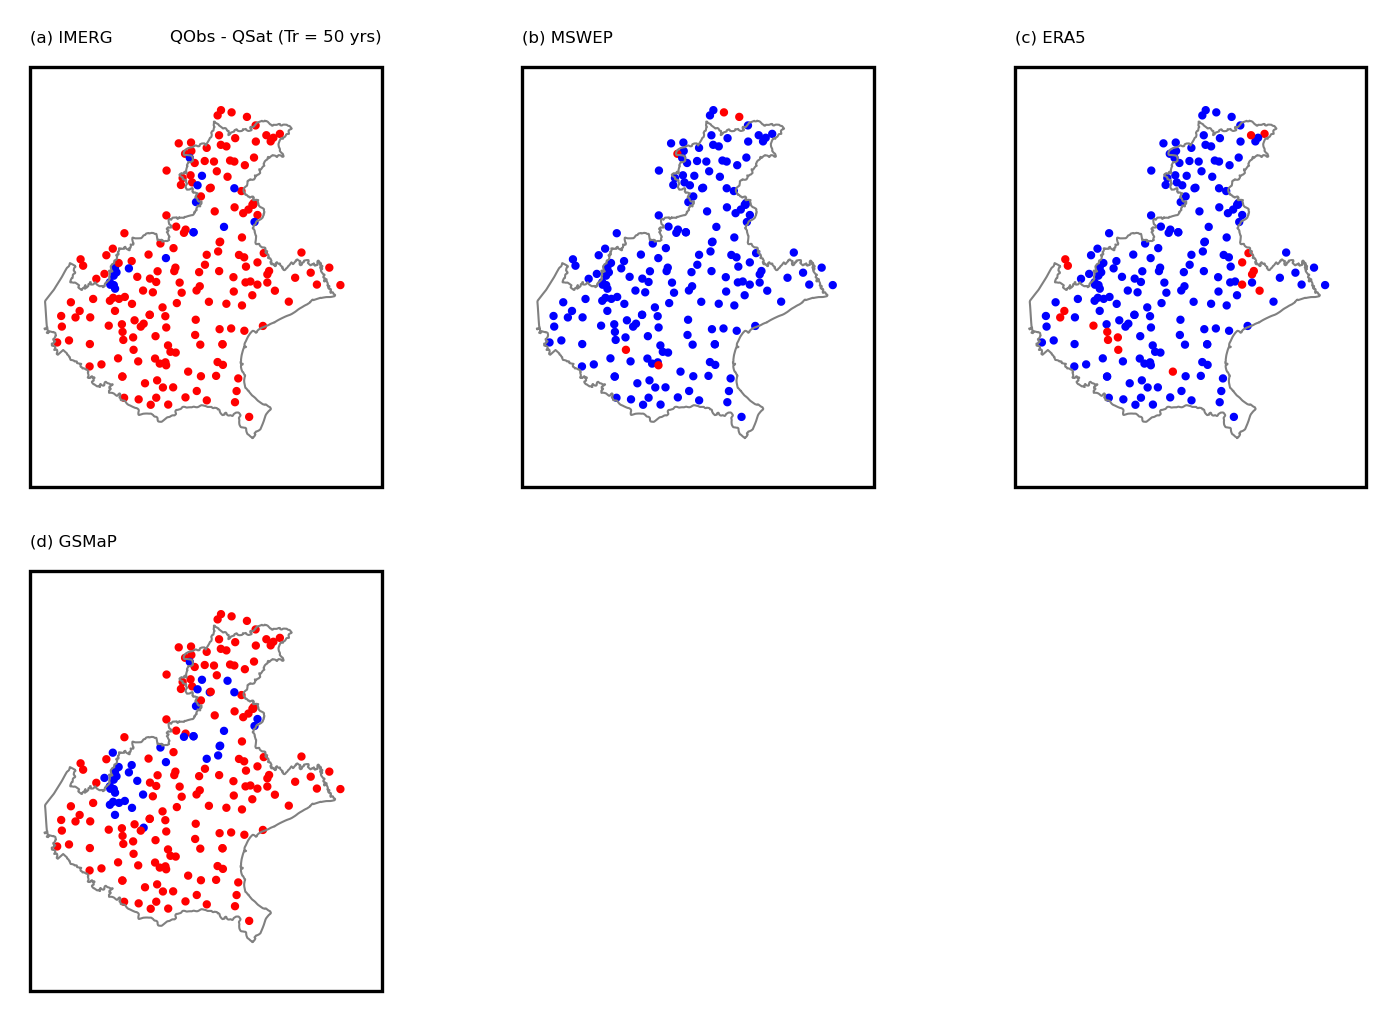

In [111]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(6,4),dpi=300)
gs = gridspec.GridSpec(2,3)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
ax1.set_extent([10.5, 13.5, 44.5, 47],crs=proj)  # Veneto
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10, edgecolor='grey')

ax1.scatter(wa_filter['Lon'], wa_filter['Lat'], s=1, c=IMERG_bin)

ax1.set_title(f'(a) IMERG', fontsize=4, loc='left')
ax1.set_title(f'QObs - QSat (Tr = 50 yrs)', fontsize=4, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
ax1.set_extent([10.5, 13.5, 44.5, 47],crs=proj)  # Veneto
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10, edgecolor='grey')

ax1.scatter(wa_filter['Lon'], wa_filter['Lat'], s=1, c=MSWEP_bin)

ax1.set_title(f'(b) MSWEP', fontsize=4, loc='left')

# ==============================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
ax1.set_extent([10.5, 13.5, 44.5, 47],crs=proj)  # Veneto
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10, edgecolor='grey')

ax1.scatter(wa_filter['Lon'], wa_filter['Lat'], s=1, c=ERA5_bin)

ax1.set_title(f'(c) ERA5', fontsize=4, loc='left')

# ==============================================================================
ax1 = plt.subplot(gs[1, 0], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
ax1.set_extent([10.5, 13.5, 44.5, 47],crs=proj)  # Veneto
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10, edgecolor='grey')

ax1.scatter(wa_filter['Lon'], wa_filter['Lat'], s=1, c=GSMaP_bin)

ax1.set_title(f'(d) GSMaP', fontsize=4, loc='left')


(np.float64(46.49998395), np.float64(11.87607301))